# Intro

In [2]:
from datetime import datetime
import pandas as pd
import numpy as np

# Stats
import statsmodels.tsa.stattools as ts  # for ADF test and coint function
import statsmodels.api as sm  # for OLS

from scipy.stats import norm  # to fit normal dist to data
import matplotlib.mlab as mlab  # to generate pdfs

# Data
import Quandl as quandl

# Plotting
%matplotlib inline

import matplotlib.pyplot as plt

import seaborn as sns

import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)
# pylab.rcParams['figure.figsize'] = (20, 10)

This report applies the techniques based on Cointegration to arrive at more robust trading strategies than simply forecasting or trend-following price levels. In summary, the following concepts will be revisited:

* Cointegration
* Mean-reversion
* Multivariate regression
* Backtesting

# Finding a cointegrated pair

This section will describe how to find a cointegrated pair in commodities based on quandl function

Look in commodities basket to see if any of them are cointegrated. Idea taken from this [Quantopian notebook](https://research-i-f355d063.prd.int.dynoquant.com/user/574c9ea0c2f60ccfbb00006f/notebooks/Cloned%20from%20%22Updated%20Pairs%20Trading%20Lecture%3A%20Now%20With%20Less%20Wind%20Resistance%22.ipynb#Looking-for-Cointegrated-Pairs-of-Alternative-Energy-Securities)

In [1]:
def find_cointegrated_pairs(data):
    n = data.shape[1]
    score_matrix = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            S1 = data[keys[i]]
            S2 = data[keys[j]]
            result = coint(S1, S2)
            score = result[0]
            pvalue = result[1]
            score_matrix[i, j] = score
            pvalue_matrix[i, j] = pvalue
            if pvalue < 0.05:  # 5% C.L. to reject null hypothesis
                pairs.append((keys[i], keys[j]))
    return score_matrix, pvalue_matrix, pairs


## Dataset

### Simulated Data

### Real Data

* For simplicity, we restrict ourselves to only two finacial series from the preselection above
* Data was taken from quandl (from Steven continuous series, method: Roll on Last Trading Day, No Price Adjustment)
* Dates with missing values in either of the series were dropped (total of six dates)
* The Gasoil (traded in metric tons) has to be converted into a price in barrels. ICE uses a conversion factor of 7.45 (ref: https://www.theice.com/publicdocs/futures/ICE_Gas_Oil_Crack.pdf). This factor is hence used to convert gasoil to barrels here.

In [52]:
# # Get quandl data from Steven continuous series, method: Roll on Last Trading Day, No Price Adjustment
# df_brent = quandl.get("SCF/ICE_B1_EN", authtoken="-uuuQ3n6PchShn5Pcu9T", trim_start = "2009-01-01", trim_end="2016-06-30")
# df_gasoil = quandl.get("SCF/ICE_G1_EN", authtoken="-uuuQ3n6PchShn5Pcu9T", trim_start = "2009-01-01", trim_end="2016-06-30")

df_brent = pd.read_csv("data/quandl_brent_010109_300616.csv", index_col=0, parse_dates=True, dayfirst=True)
df_gasoil = pd.read_csv("data/quandl_gasoil_010109_300616.csv", index_col=0, parse_dates=True, dayfirst=True)

In [20]:
# Check number of missing values for each series independently
print df_gasoil.isnull().sum()
print df_brent.isnull().sum()

Date                       0
Open                       0
High                       0
Low                        0
Settle                     0
Volume                     0
Prev. Day Open Interest    0
dtype: int64
Date                       0
Open                       0
High                       0
Low                        0
Settle                     0
Volume                     0
Prev. Day Open Interest    0
dtype: int64


In [53]:
# Keep only CLOSE
df_brent = df_brent['Settle']
df_gasoil = df_gasoil['Settle'] / 7.45  # use the ICE factor to convert gasoil metric tons to barrels

In [54]:
# Concatenate
df = pd.concat([df_brent, df_gasoil], axis=1, join='outer', keys=['brent', 'gasoil'])
df.head()

,brent,gasoil
Date,,
2009-01-02,46.91,57.416107
2009-01-05,49.62,64.261745
2009-01-06,50.53,69.060403
2009-01-07,45.86,67.181208
2009-01-08,44.67,64.194631


In [55]:
# Count missing values of joined series
print 'BEFORE CLEANUP'
print df.isnull().sum()
print df.shape

# Remove missing values
df = df.dropna()
print 'AFTER CLEANUP'
print df.isnull().sum()
print df.shape

BEFORE CLEANUP
brent     6
gasoil    0
dtype: int64
(1941, 2)
AFTER CLEANUP
brent     0
gasoil    0
dtype: int64
(1935, 2)


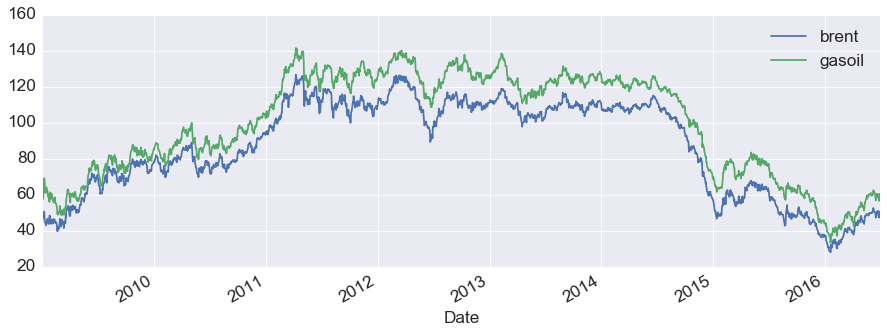

In [56]:
_ = df.plot()

# Multivariate Regression

Multivariate regression generalizes linear regression, allowing the dependent variable to be a linear function of multiple independent variables. As before, we assume that the variable $Y$ is a linear function of $X_1,\ldots, X_k$:

$$ Y_i = \alpha + \beta_1 X_{1i} + \ldots + \beta_k X_{ki} + \epsilon_i $$

For observations $i = 1,2,\ldots, n$. In order to find the plane (or hyperplane) of best fit, we will use the method of ordinary least-squares (OLS), which seeks to minimize the squared error between predictions and observations, $\sum_{i=1}^n \epsilon_i^2$. The square makes makes positive and negative errors equally bad, and magnifies large errors. 

Once we have used this method to determine the coefficients of the regression, we will be able to use new observed values of $X$ to predict values of $Y$. 

Each coefficient $\beta_j$ tells us how much $Y_i$ will change if we change $X_j$ by one while holding all of the other dependent variables constant. This lets us separate out the contributions of different effects. This is assuming the linear model is the correct one.

# Cointegration

In [3]:
df = pd.read_csv("data/df_brent_gasoil.csv", index_col=0, parse_dates=True, dayfirst=True)
print df.head()
print df.tail()

            brent     gasoil
Date                        
2009-01-02  46.91  57.416107
2009-01-05  49.62  64.261745
2009-01-06  50.53  69.060403
2009-01-07  45.86  67.181208
2009-01-08  44.67  64.194631
            brent     gasoil
Date                        
2016-06-24  48.41  58.389262
2016-06-27  47.16  56.476510
2016-06-28  48.58  57.516779
2016-06-29  50.61  60.402685
2016-06-30  49.68  59.395973


Cointegration is a time series concept that allows us to determine if we are able to form a mean reverting pair of assets. 

When two time series (or more) are cointegrated, a linear combination exists which can lead to a stationary series. A series is stationary when its generating process parameters do not change over time or space, in particular the mean and variance do not change and this means the series reverts to its mean. Trading strategies can threfore exploit the mean-reversion property.

Though this property is the basis of many trading strategies, such as 'pairs trading' and mean-reversion, it is often untested and 'taken for granted'.

* When two series are cointegrated it means we can find some linear combination of $Y$ and $X$ that is stationary. If we assume this linear combination is as simple as $Y- X$, this should give a stationary series representing the 'noise' in the series

## Simulated data example

X1 and X2 simulated to be cointegrated. If X2 is supposed to have a deep economic link to X1, the price of X2 should vary pretty similarly. We model this by taking X1, shifting it up and adding some random noise drawn from a normal distribution.

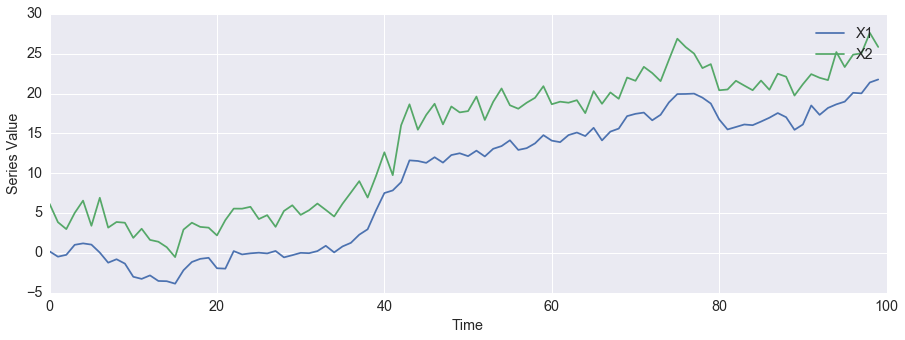

In [265]:
N = 100 # length of series

# Generate a stationary random X1
X1 = np.random.normal(0, 1, N)
# Integrate it to make it I(1)
X1 = np.cumsum(X1)
X1 = pd.Series(X1)
X1.name = 'X1'

# Make an X2 that is X1 plus some noise
some_noise = np.random.normal(0, 1, N)
shift = 5.0
X2 = X1 + shift + some_noise
X2.name = 'X2'

plt.plot(X1)
plt.plot(X2)
plt.xlabel('Time')
plt.ylabel('Series Value')
plt.legend([X1.name, X2.name]);

In [266]:
check_for_stationarity(X2.diff()[1:]);

p-value = 1.83785210524e-18 The series is likely stationary.


Looks good. Now to show cointegration we'll need to find some linear combination of  X1X1  and  X2X2  that is stationary. We can take  X2−X1X2−X1 . All that's left over should be stationary noise by design. Let's check this.

p-value = 2.30485989773e-18 The series is likely stationary.


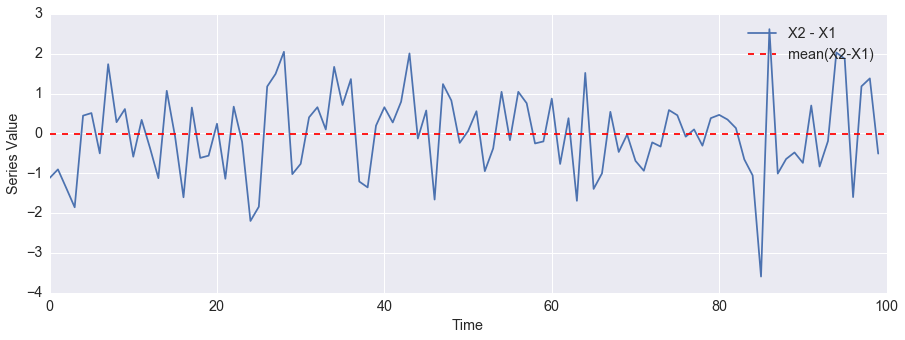

In [221]:
plt.plot(X2 - X1)
plt.axhline((X2-X1).mean(), color='red', linestyle='--') # Add the mean
plt.xlabel('Time')
plt.ylabel('Series Value')
plt.legend(['X2 - X1', 'mean(X2-X1)']);

check_for_stationarity(X2- X1);

## Real data example

The figures below show $Y/X$ and $Y-X$ for gasoil and brent and ther respective means. Indeed both appear to be mean-reverting but a more robust test should be done to ascertain this.

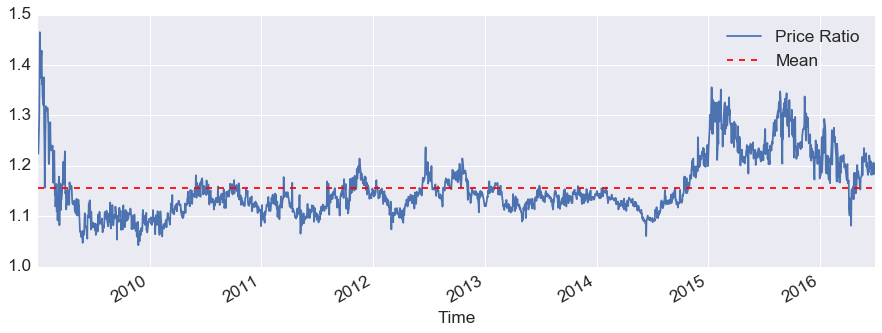

In [4]:
Y = df['gasoil']
X = df['brent']
(Y/X).plot()
plt.axhline((Y/X).mean(), color='red', linestyle='--') # Add the mean
plt.xlabel('Time')
plt.legend(['Price Ratio', 'Mean']);

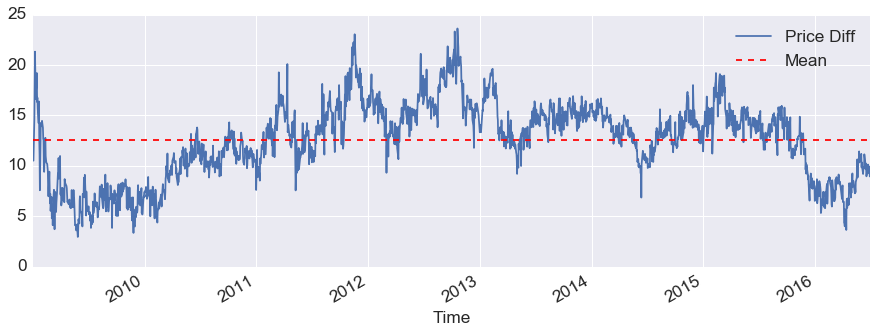

In [6]:
(Y - X).plot()
plt.axhline((Y-X).mean(), color='red', linestyle='--') # Add the mean
plt.xlabel('Time')
plt.legend(['Price Diff', 'Mean']);

## Vector Autoregression

In [5]:
X.head()

Date
2009-01-02    46.91
2009-01-05    49.62
2009-01-06    50.53
2009-01-07    45.86
2009-01-08    44.67
Name: brent, dtype: float64

In [6]:
import statsmodels.tsa.api
# Univariate autoregression must be on stationary series, hence diff
model = statsmodels.tsa.api.AR(X.diff().dropna())

In [12]:
for i in range(20):
    results = model.fit(maxlag=i)
    print 'lag={0}, aic={1}, bic={2}'.format(i, results.aic, results.bic)

lag=0, aic=0.785579522161, bic=0.791336859985
lag=1, aic=0.783837872098, bic=0.792477543819
lag=2, aic=0.784398355505, bic=0.795922808952
lag=3, aic=0.780544184544, bic=0.794955870931
lag=4, aic=0.781352524552, bic=0.798653898485
lag=5, aic=0.7828508456, bic=0.803044365087
lag=6, aic=0.782689264944, bic=0.805777391397
lag=7, aic=0.783424446286, bic=0.809409644529
lag=8, aic=0.784896385959, bic=0.813781124237
lag=9, aic=0.78622752825, bic=0.818014278232
lag=10, aic=0.786070187357, bic=0.820761424142
lag=11, aic=0.786166097216, bic=0.823764299344
lag=12, aic=0.787422158181, bic=0.827929807637
lag=13, aic=0.788229584214, bic=0.831649166433
lag=14, aic=0.789519265514, bic=0.835853269389
lag=15, aic=0.788601189924, bic=0.837852107815
lag=16, aic=0.789229350698, bic=0.841399678434
lag=17, aic=0.787909032094, bic=0.843001268984
lag=18, aic=0.7891008468, bic=0.847117495637
lag=19, aic=0.790418901754, bic=0.851362468821


In [8]:
# Select optimal lag based on info criterion
model.select_order(5, 'bic')  # --> gives an error

# Granger Causality

One is often interested in whether a variable or group of variables is “causal” for another variable, i.e. determining the best choice for the independent variable and the dependent variable. Several tests exist for this such as Wald ad F tests. In addition, the test is useful to determine whether a variable can be treated as exogenous, and therefore, dropped from VAR(p) system. 

Note: High correlation across time series could also be a problem: Granger causality testing would show that two highly correlated variables X, Y ‘cause a third variable without identifying whether X or Y has the stronger impact

In [73]:
from statsmodels.tsa import stattools
# Granger causality

# The Null hypothesis for grangercausalitytests is that the time series in the second column, x2,
# does NOT Granger cause the time series in the first column, x1. 
# Grange causality means that past values of x2 have a statistically significant effect on 
# the current value of x1, taking past values of x1 into account as regressors. 
# We reject the null hypothesis that x2 does not Granger cause x1 if the pvalues are below
# a desired size of the test.

temp = df.diff().dropna()  # on differences
# test if gasoil causes brent moves, i.e. is gasoil X and brent Y?
stattools.grangercausalitytests(temp[['brent', 'gasoil']], maxlag=3)


Granger Causality
('number of lags (no zero)', 1)
ssr based F test:         F=0.1851  , p=0.6670  , df_denom=1930, df_num=1
ssr based chi2 test:   chi2=0.1854  , p=0.6667  , df=1
likelihood ratio test: chi2=0.1854  , p=0.6668  , df=1
parameter F test:         F=0.1851  , p=0.6670  , df_denom=1930, df_num=1

Granger Causality
('number of lags (no zero)', 2)
ssr based F test:         F=0.4169  , p=0.6592  , df_denom=1927, df_num=2
ssr based chi2 test:   chi2=0.8359  , p=0.6584  , df=2
likelihood ratio test: chi2=0.8357  , p=0.6584  , df=2
parameter F test:         F=0.4169  , p=0.6592  , df_denom=1927, df_num=2

Granger Causality
('number of lags (no zero)', 3)
ssr based F test:         F=1.1515  , p=0.3270  , df_denom=1924, df_num=3
ssr based chi2 test:   chi2=3.4671  , p=0.3251  , df=3
likelihood ratio test: chi2=3.4640  , p=0.3255  , df=3
parameter F test:         F=1.1515  , p=0.3270  , df_denom=1924, df_num=3


{1: ({'lrtest': (0.18542215556590236, 0.66675434718058613, 1),
   'params_ftest': (0.18514326166484335, 0.66703800045586781, 1930.0, 1L),
   'ssr_chi2test': (0.18543104911870978, 0.66674683727532069, 1),
   'ssr_ftest': (0.18514326166534395, 0.6670380004551435, 1930.0, 1)},
   array([[ 0.,  1.,  0.]])]),
 2: ({'lrtest': (0.83574249268804124, 0.65844700042593085, 2),
   'params_ftest': (0.41687995926201782, 0.65915946134796899, 1927.0, 2L),
   'ssr_chi2test': (0.83592328105271496, 0.6583874833377551, 2),
   'ssr_ftest': (0.41687995926205534, 0.65915946134796899, 1927.0, 2)},
   array([[ 0.,  0.,  1.,  0.,  0.],
          [ 0.,  0.,  0.,  1.,  0.]])]),
 3: ({'lrtest': (3.4639573479516912, 0.32546690614309737, 3),
   'params_ftest': (1.1514992689748407, 0.32700196076536908, 1924.0, 3L),
   'ssr_chi2test': (3.4670661461394903, 0.325058718377149, 3),
   'ssr_ftest': (1.1514992689750352, 0.32700196076534455, 1924.0, 3)},
   array([[ 0.,  0.,  0.,  1.,  0.,  0.,  0.],
          [ 0.,  0.,  0.

In [74]:
# test if brent causes gasoil moves, i.e. is brent X and gasoil Y?
stattools.grangercausalitytests(temp[['gasoil', 'brent']], maxlag=3)


Granger Causality
('number of lags (no zero)', 1)
ssr based F test:         F=203.8856, p=0.0000  , df_denom=1930, df_num=1
ssr based chi2 test:   chi2=204.2026, p=0.0000  , df=1
likelihood ratio test: chi2=194.1207, p=0.0000  , df=1
parameter F test:         F=203.8856, p=0.0000  , df_denom=1930, df_num=1

Granger Causality
('number of lags (no zero)', 2)
ssr based F test:         F=137.3961, p=0.0000  , df_denom=1927, df_num=2
ssr based chi2 test:   chi2=275.5051, p=0.0000  , df=2
likelihood ratio test: chi2=257.5496, p=0.0000  , df=2
parameter F test:         F=137.3961, p=0.0000  , df_denom=1927, df_num=2

Granger Causality
('number of lags (no zero)', 3)
ssr based F test:         F=93.0952 , p=0.0000  , df_denom=1924, df_num=3
ssr based chi2 test:   chi2=280.3016, p=0.0000  , df=3
likelihood ratio test: chi2=261.7341, p=0.0000  , df=3
parameter F test:         F=93.0952 , p=0.0000  , df_denom=1924, df_num=3


{1: ({'lrtest': (194.12067527581712, 4.0079840383371141e-44, 1),
   'params_ftest': (203.88564296222168, 4.781307134734796e-44, 1930.0, 1L),
   'ssr_chi2test': (204.20256365076432, 2.5280451231589192e-46, 1),
   'ssr_ftest': (203.88564296222199, 4.7813071347337087e-44, 1930.0, 1)},
   array([[ 0.,  1.,  0.]])]),
 2: ({'lrtest': (257.54958015654938, 1.1852753724344659e-56, 2),
   'params_ftest': (137.39605645549085, 1.6540771163304076e-56, 1927.0, 2L),
   'ssr_chi2test': (275.5051178744244, 1.4956286833550731e-60, 2),
   'ssr_ftest': (137.39605645549065, 1.6540771163308778e-56, 1927.0, 2)},
   array([[ 0.,  0.,  1.,  0.,  0.],
          [ 0.,  0.,  0.,  1.,  0.]])]),
 3: ({'lrtest': (261.73409737942802, 1.8953219612791217e-56, 3),
   'params_ftest': (93.095158652462317, 2.9406181659633885e-56, 1924.0, 3L),
   'ssr_chi2test': (280.30158735640015, 1.8221229866616414e-60, 3),
   'ssr_ftest': (93.09515865246226, 2.940618165963806e-56, 1924.0, 3)},
   array([[ 0.,  0.,  0.,  1.,  0.,  0.,  0

## Stationarity and Mean-Reversion

If a time series display a tendency to revert to its historical mean value, the series is referred to as an  Ornstein-Uhlenbeck process. This is in contrast to a random walk (Brownian motion), which has no "memory" of where it has been at each particular instance of time. The mean-reverting property of a time series can be exploited in order to produce profitable trading strategies.

There are several tests that can be used to identify mean-reversion based on how stationary the series is.

A continuous mean-reverting time series can be represented by an Ornstein-Uhlenbeck stochastic differential equation:

$$dX = \theta (\mu - X) dt + \sigma dW $$

Where $\theta$ is the speed of reversion to the mean, $\mu$ is the mean value of the process, $\sigma$ is the variance of the process and $W$ is a Wiener Process or Brownian Motion.

In a discrete setting the equation states that the change of the price series in the next time period is proportional to the difference between the mean price and the current price, with the addition of Gaussian noise.

This property motivates the Augmented Dickey-Fuller Test, which we will describe below.

### ADF


To test for stationarity we can use the ADF test, which is based on testing for the presence of a _unit root_ in an _autoregression_ time series sample.If the series is mean reverting, then the next price level will be proportional to the current level. A linear lag model of order $p$ is used:

$$ 
\Delta y_t = \alpha + \beta t + \gamma y_{t-1} + \delta_i \Delta y_{t-1} + \dots + \delta_{p-1} \Delta y_{t-p+1} + \epsilon_t
$$

A _test statistic_ is constructed from the estimate $\hat{\gamma}$. This and the p-value are then used to reject the null hypothesis - the series has a unit root ($\gamma=0$)  and hence is not mean-reverting - if they are below a prescribed threshold.

In practice, any constant long-term drift in pa price is of  a much smaller magnitude than any short-term fluctuations and so the drift is often assumed to be zero ($\beta = 0$) for the model. Also, it is usually sufficient to set $p=1$ to reject the null hypothesis.

In [168]:
#     Augmented Dickey-Fuller unit root test

#     The Augmented Dickey-Fuller test can be used to test for a unit root in a
#     univariate process in the presence of serial correlation.
#     Notes
#     -----
#     The null hypothesis of the Augmented Dickey-Fuller is that there is a unit
#     root, with the alternative that there is no unit root. If the pvalue is
#     above a critical size, then we cannot reject that there is a unit root.

#     The p-values are obtained through regression surface approximation from
#     MacKinnon 1994, but using the updated 2010 tables.
#     If the p-value is close to significant, then the critical values should be
#     used to judge whether to accept or reject the null.

from statsmodels.tsa.stattools import adfuller

def check_for_stationarity(X, cutoff=0.01):
    # H_0 in adfuller is unit root exists (non-stationary)
    # We must observe significant p-value to convince ourselves that the series is stationary
    pvalue = adfuller(X)[1]
    if pvalue < cutoff:
        print 'p-value = ' + str(pvalue) + ' The series is likely stationary.'
        return True
    else:
        print 'p-value = ' + str(pvalue) + ' The series is likely non-stationary.'
        return False

In [170]:
print 'X:  ', check_for_stationarity(X);
print 'Y:  ', check_for_stationarity(Y);
print 'Y/X:  ', check_for_stationarity(Y/X);
print 'X/Y:  ', check_for_stationarity(X/Y);
print 'Y-X:  ', check_for_stationarity(Y-X);

s = Y/X
print 'Full result for Y/X:  ', adfuller(s.dropna())

X:   p-value = 0.677364125247 The series is likely non-stationary.
False
Y:   p-value = 0.725401939861 The series is likely non-stationary.
False
Y/X:   p-value = 0.0494486558748 The series is likely non-stationary.
False
X/Y:   p-value = 0.0556154082177 The series is likely non-stationary.
False
Y-X:   p-value = 0.0160867298062 The series is likely non-stationary.
False
Full result for Y/X:   (-2.8659867351705772, 0.049448655874800129, 25L, 1909L, {'5%': -2.8630552063395585, '1%': -3.4337801282776335, '10%': -2.5675766377428086}, -10376.019204241331)


The first value is the calculated test-statistic, while the second value is the p-value. The fourth is the number of data points in the sample. The fifth value, the dictionary, contains the critical values of the test-statistic at the 1, 5 and 10 percent values respectively.
Since the calculated value of the test statistic is larger than any of the critical values at the 1, 5 or 10 percent levels, we cannot reject the null hypothesis of $\gamma=0$ and thus we are unlikely to have found a mean reverting time series.

#### Important Note

We shouldn't assume that because a time series is stationary in the past it will continue to be stationary in the future. Tests for consistency of stationarity such as cross validation and out of sample testing are necessary. This is true of any statistical property. Returns may also go in and out of stationarity, and may be stationary or non-stationary depending on the timeframe and sampling frequency. Below we see an example where this is the case

All above appear to be non stationary based on the pvalue criteria, however, if we slice the dataset to include only data from 2010-2015, the series passes the ADF test and the value is significantly smaller

In [185]:
print 'Y-X 2010-2015 :  ', check_for_stationarity(Y[datetime(2010, 1, 4):datetime(2015, 12, 31)] - X[datetime(2010, 1, 4):datetime(2015, 12, 31)])

Y-X 2010-2015 :   p-value = 0.000982989775234 The series is likely stationary.
True


How about 2010-2016 YTD:

In [186]:
print 'Y-X 2010-2016 YTD :  ', check_for_stationarity(Y[datetime(2010, 1, 4):] - X[datetime(2010, 1, 4):])

Y-X 2010-2016 YTD :   p-value = 0.00950781597519 The series is likely stationary.
True


So we could slice the data to get better pvalues...

Taking additive returns (delta of each series):

In [188]:
print 'X.diff:  ', check_for_stationarity(X.diff()[1:]);
print 'Y.diff:  ', check_for_stationarity(Y.diff()[1:]);

 X.diff:   p-value = 0.0 The series is likely stationary.
True
Y.diff:   p-value = 0.0 The series is likely stationary.
True


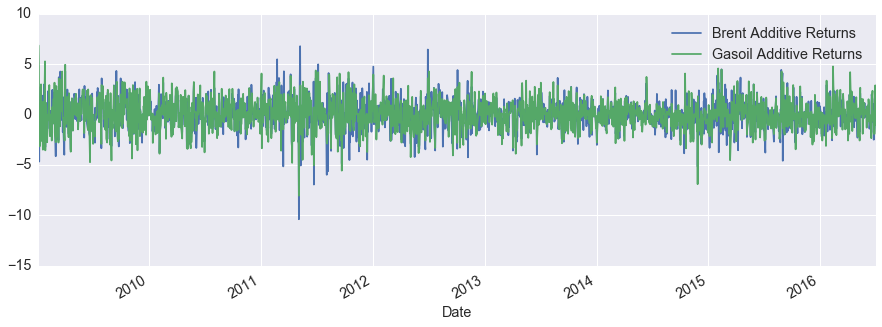

In [196]:
X.diff()[1:].plot(label='Brent Additive Returns')
Y.diff()[1:].plot(label='Gasoil Additive Returns')
plt.legend()

Taking multiplicative returns:

X.pct_change:   p-value = 2.00768925805e-18 The series is likely stationary.
True
Y.pct_change:   p-value = 8.35204928935e-29 The series is likely stationary.
True


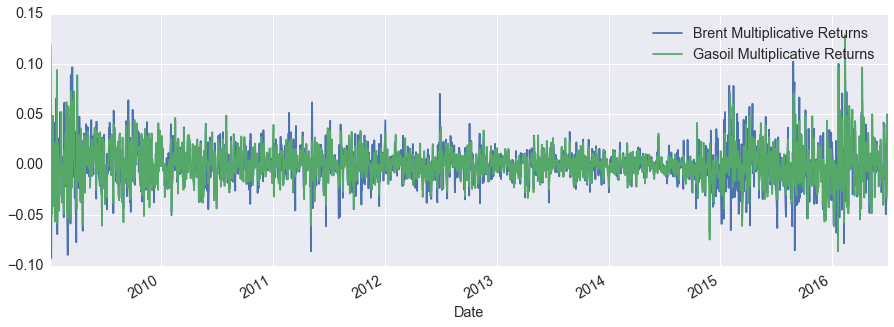

In [198]:
print 'X.pct_change:  ', check_for_stationarity(X.pct_change()[1:]);
print 'Y.pct_change:  ', check_for_stationarity(Y.pct_change()[1:]);

X.pct_change()[1:].plot(label='Brent Multiplicative Returns')
Y.pct_change()[1:].plot(label='Gasoil Multiplicative Returns')
plt.legend()

We will slice the dataset to start in 2010 for the rest of the analysis

In [214]:
df = df[df.index > datetime(2010, 1, 1)]

#### Autocorrelation plot

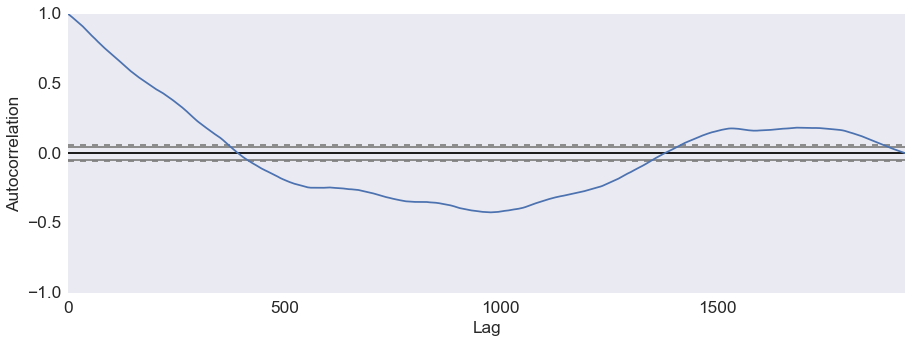

In [24]:
autocorrelation_plot(X)

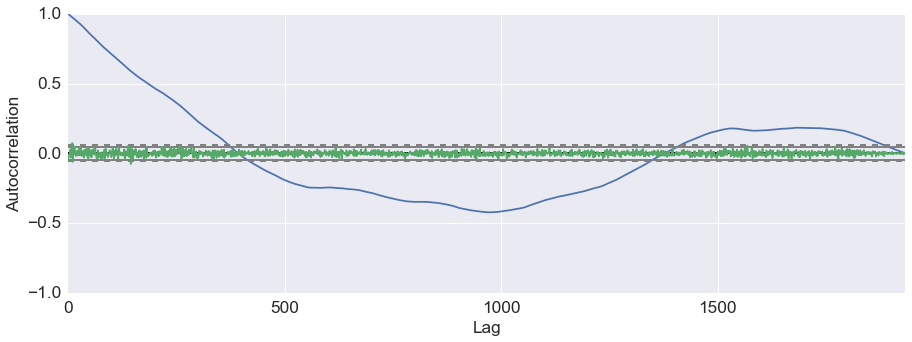

In [38]:
a = pd.concat([X[1:], X.pct_change()[1:]], keys=['level', 'pct_change'], axis=1)
autocorrelation_plot(a['level'])
autocorrelation_plot(a['pct_change'])

#### Lag plot

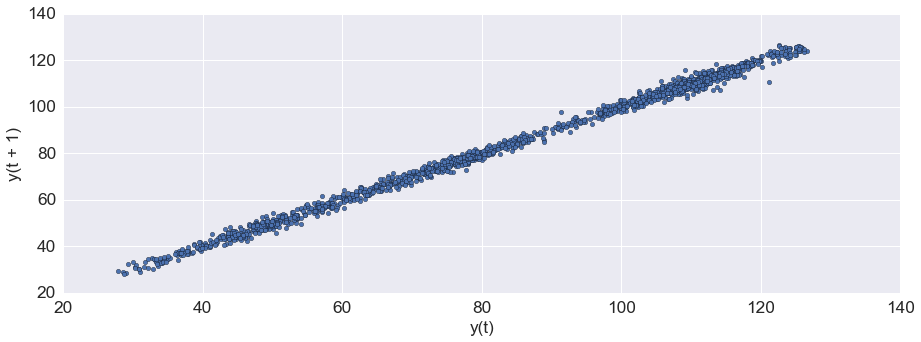

In [41]:
from pandas.tools.plotting import lag_plot
lag_plot(a['level'])

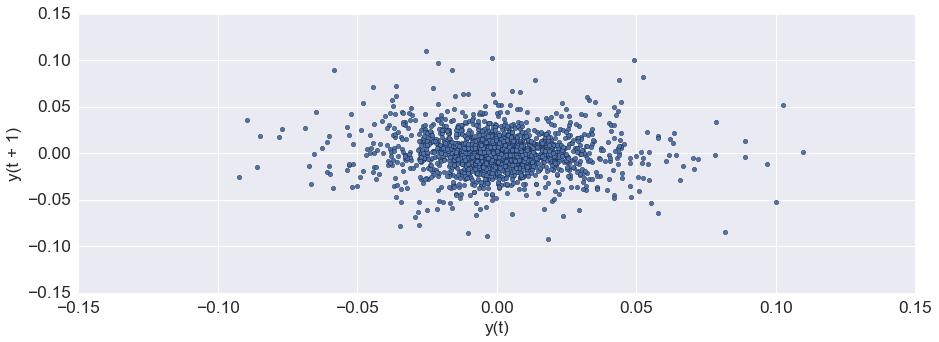

In [42]:
lag_plot(a['pct_change'])

#### Price level vs Returns

From the above results we see only returns are stationary. In general  returns are usually used for modeling in quantitive finance is that they are far more stationary than prices. This makes them easier to model and returns forecasting more feasible. Forecasting prices is more difficult

### Order of integration

See [here](https://www.quantopian.com/research/notebooks/Cloned%20from%20%22Quantopian%20Lecture%20Series%3A%20Integration%2C%20Cointegration%2C%20and%20Stationarity%22.ipynb)

## Testing for Cointegration

The idea is to test statistically whether the difference (or ratio) between the series is stationary. There are various tests available for this, such as:

* Augmented-Dickey Fuller test
* Hurst exponent
* Half-life of mean reversion inferred from an Ornstein–Uhlenbeck process
* Kalman filters

Below is a simple test from stattools:

In [166]:
#     This is a simple cointegration test. Uses unit-root test on residuals to
#     test for cointegrated relationship
#     See Hamilton (1994) 19.2
#     Returns
#     -------
#     coint_t : float
#         t-statistic of unit-root test on residuals
#     pvalue : float
#         MacKinnon's approximate p-value based on MacKinnon (1994)
#     crit_value : dict
#         Critical values for the test statistic at the 1 %, 5 %, and 10 %
#         levels.
#     Notes
#     -----
#     The Null hypothesis is that there is no cointegration, the alternative
#     hypothesis is that there is cointegrating relationship. If the pvalue is
#     small, below a critical size, then we can reject the hypothesis that there
#     is no cointegrating relationship.     

import statsmodels.tsa.stattools as ts
t_stat, pvalue, crit_val = ts.coint(X,Y)
print "t_stat={0}, crit_val={1}, pvalue={2}".format(t_stat, crit_val, pvalue)

t_stat=-8.74721510123, crit_val=[-3.43373398 -2.86303483 -2.56756579], pvalue=3.85041949855e-13


The low p-value and t-statistic compared to the critical values confirm our hypothesis for cointegration.

In [70]:
# Testing for cointegration on the series itself
t_stat, pvalue, crit_val = ts.coint(X,X)
print "t_stat={0}, crit_val={1}, pvalue={2}".format(t_stat, crit_val, pvalue)

t_stat=-3.17063349832, crit_val=[-3.43373398 -2.86303483 -2.56756579], pvalue=0.0749776848281


Note that correlation is different to cointegration. In this case the series are highly correlated as one would expect since gasoil is a refined product of crude. However this doesn't imply cointegration

In [71]:
X.corr(Y)

0.99356909069484867

## Finding the optimal weights $\beta$

### Factor models

Factor models are a way of explaining the returns of one asset via a linear combination of the returns of other assets. The general form of a factor model is

$$Y = \alpha + \beta_1 X_1 + \beta_2 X_2 + \dots + \beta_n X_n$$

This looks familiar, as it is exactly the model type that a linear regression fits.

As we have seen, to statistically confirm whether a series is mean-reverting we could use a statistical test, like ADF or Hurst Exponent. However, neither of these tests will actually help us determine $\beta_i$, the optimal weights (also referred to as 'hedging ratios') needed to form the linear combination, they will only tell us whether, for a particular $\beta_i$, the linear combination is stationary.

Often "beta" is interpreted as a stock's exposure to another asset.

To estimate the optimal linear combination, a common practice is to use linear regression:

$$Y = \alpha + \beta X + \epsilon$$

If $X$ and $Y$ are cointegrated, the residual $ \epsilon + \alpha  = Y - \beta X$ should be stationary

### Using Price Levels

For our real data, if we create a scatter plot of the Brent and Gasoil series, we see that the relationship is broadly linear  for this period. If we plot the line $\beta x + \epsilon$, we can see that it does indeed look like the line of best fit.

In [235]:
# Quantopian version
import statsmodels.api as sm

# Let's define everything in familiar regression terms
def linreg(x,y):
    # We add a constant so that we can also fit an intercept (alpha) to the model
    # This just adds a column of 1s to our data
    x = sm.add_constant(x)
    # model = regression.linear_model.OLS(y,x).fit()
    model = sm.OLS(y, x).fit()
    # Remove the constant now that we're done
    x = x.iloc[:, 1]
    print model.summary()
    return model.params[0], model.params[1]

alpha, beta = linreg(X,Y)
print 'alpha: ' + str(alpha)
print 'beta: ' + str(beta)

                            OLS Regression Results                            
Dep. Variable:                 gasoil   R-squared:                       0.987
Model:                            OLS   Adj. R-squared:                  0.987
Method:                 Least Squares   F-statistic:                 1.488e+05
Date:                Sun, 10 Jul 2016   Prob (F-statistic):               0.00
Time:                        16:07:05   Log-Likelihood:                -5011.4
No. Observations:                1935   AIC:                         1.003e+04
Df Residuals:                    1933   BIC:                         1.004e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          6.1134      0.252     24.303      0.0

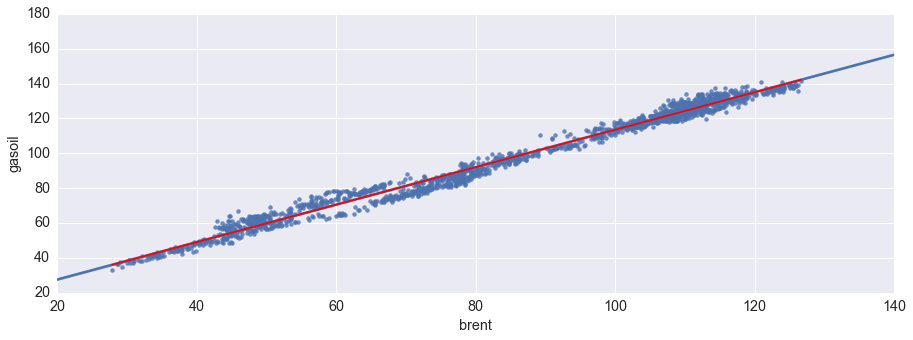

In [238]:
# generate equally spaced X values between true X range
x = np.linspace(X.min(), X.max(), 100)
# y estimate using OLS beta and alpha
y_hat = beta * x + alpha

# Plot on top or seaborn scatter + fit
result = sns.regplot(x=X, y=Y)
ax = result.plot(x, y_hat, 'r')

p-value = 0.000441030040986 The series is likely stationary.


True

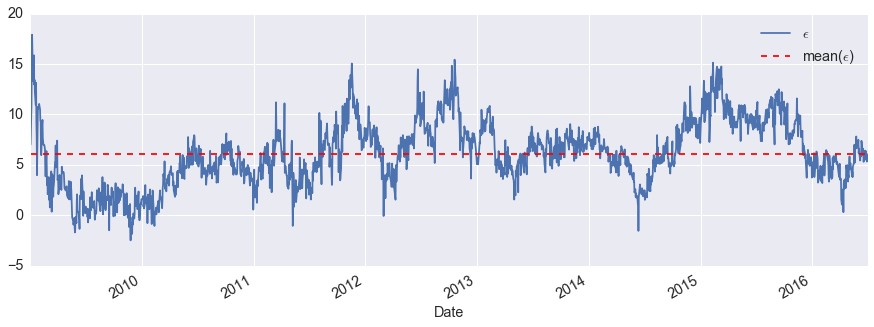

In [264]:
# # Now test for stationarity of residuals using Beta weight
epsilon = pd.Series(data=(Y - beta * X), name='epsilon')
epsilon.plot()
plt.axhline(epsilon.mean(), color='red', linestyle='--') # Add the mean
plt.legend(['$\epsilon$', 'mean($\epsilon$)'])

# Check for stationarity
check_for_stationarity(epsilon)

We can see here that the resulting $\epsilon$ was likely stationary over the time frame we looked at. This causes us to accept the hypothesis that our two assets were cointegrated over the same timeframe.

mu=6.11344233066, sigma=3.22500899088
normalised_ratio.mean=-9.40046203383e-16, normalised_ratio.std=1.00025849813


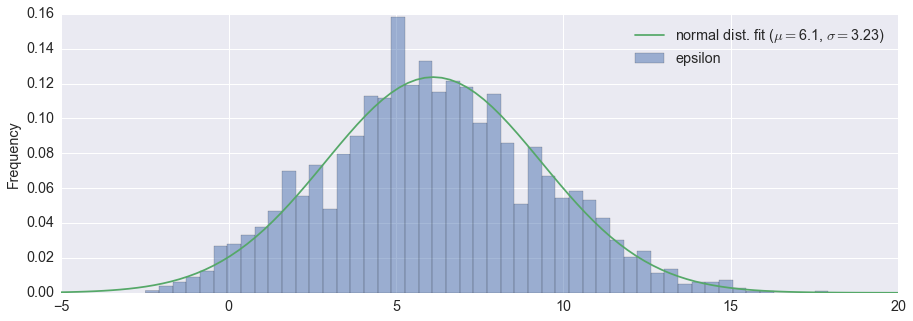

In [281]:
_ = epsilon.plot.hist(bins=50, alpha=0.5, normed=True)

# Get the mu and sigma of the data assuming a gaussian distribution
(mu, sigma) = norm.fit(epsilon)  # because this has been normalised, mu should be close to zero and sigma close to one
print "mu={0}, sigma={1}".format(mu, sigma)
print "normalised_ratio.mean={0}, normalised_ratio.std={1}".format(normalised_ratio.mean(), normalised_ratio.std())


# Fit a normal pdf with mu and sigma as above
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
_ = plt.plot(x, mlab.normpdf(x, mu, sigma), label="normal dist. fit ($\mu=${0:.2g}, $\sigma=${1:.2f})".format(mu, sigma))
_ = plt.legend()

Also residual looks pretty normal

-5.0 20.0


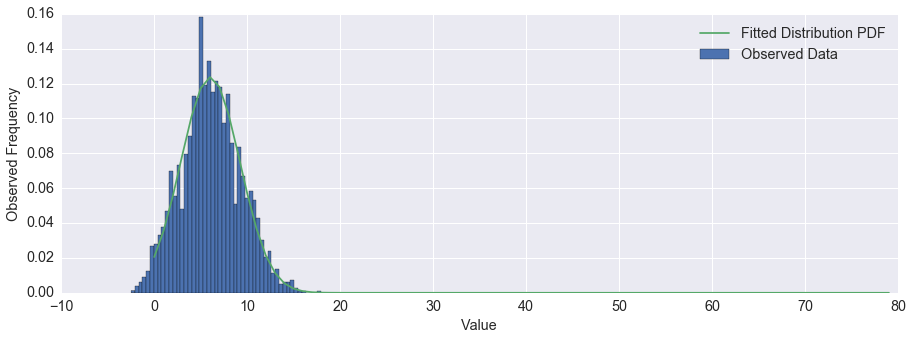

In [313]:
# Quandl version

import scipy
import scipy.stats

_ = plt.hist(epsilon, bins=50, normed=True)
xmin, xmax = plt.xlim()
print xmin, xmax
x = np.linspace(0, 80, 80)
plt.plot(scipy.stats.norm.pdf(x, loc=mu, scale=sigma))
plt.xlabel('Value')
plt.ylabel('Observed Frequency')
plt.legend(['Fitted Distribution PDF', 'Observed Data', ]);

Of course, this fit is meaningless unless we've tested that they obey a normal distribution first. We can test this using the Jarque-Bera normality test. The Jarque-Bera test will reject the hypothesis of a normal distribution if the p-value is under a critical value

In [317]:
# Calculate residual skewness, kurtosis, and do the JB test for normality
# see http://statsmodels.sourceforge.net/devel/_modules/statsmodels/stats/stattools.html

# Returns JB, JBpv, skew, kurtosis
from statsmodels.stats.stattools import jarque_bera
jarque_bera(epsilon)

(10.310531273501937,
 0.0057689474270911168,
 0.15546281559856653,
 2.8233426755107613)

### Using Differences (Returns)

                            OLS Regression Results                            
Dep. Variable:                 gasoil   R-squared:                       0.441
Model:                            OLS   Adj. R-squared:                  0.441
Method:                 Least Squares   F-statistic:                     1525.
Date:                Sun, 10 Jul 2016   Prob (F-statistic):          1.95e-246
Time:                        17:20:56   Log-Likelihood:                 5552.9
No. Observations:                1934   AIC:                        -1.110e+04
Df Residuals:                    1932   BIC:                        -1.109e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const       4.169e-05      0.000      0.134      0.8

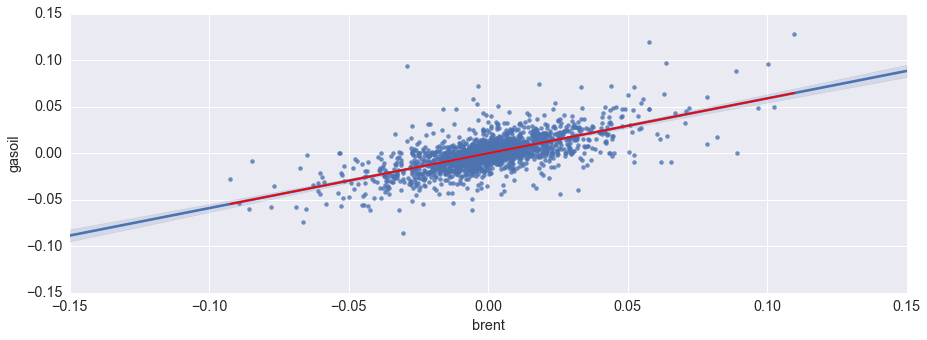

In [267]:
r_a = X.pct_change()[1:]
r_b = Y.pct_change()[1:]

alpha, beta = linreg(r_a,r_b)
print 'alpha: ' + str(alpha)
print 'beta: ' + str(beta)

# generate equally spaced X values between true X range
x = np.linspace(r_a.min(), r_a.max(), 100)
# y estimate using OLS beta and alpha
y_hat = beta * x + alpha

# Plot on top or seaborn scatter + fit
result = sns.regplot(x=r_a, y=r_b)
ax = result.plot(x, y_hat, 'r')

# Trading Strategies

Hedging is one of the best ways to perform risk management in practice. Below we describe a few strategies which exploit the cointegration properties. Most are based on obtaining optimal hedging ratios by performing linear regressions against the a stationary series.

Firsty, it should be noted that it is actually very difficult to find a directly tradable asset that possesses mean-reverting behaviour. However, there is nothing preventing us from creating a portfolio of price series that is stationary and for which mean-reverting trading strategies can be applied.

In practice, we are interested in carrying out mean reversion trading not solely on a pair of assets, but also baskets of assets that are separately interrelated, but for simplicity below we will stick to just the two assets before: gasoil and brent.

For trade design, long waiting times mean cost of carry (financing of the leverage) and increase the risk of regime change in the co-integrating relationship. Estimate half-life time of a co-integrating relationship returning to its equilibrium and explore trading partial half life.

** Cautionary note**

as with anything else, you should not assume that because some set of assets have passed a cointegration test historically, they will continue to remain cointegrated. You need to verify that consistent behavior occurs, and use various model validation techniques as you would with any model.
One of the most important things done in finance is to make many independent bets. Here a quant would find many pairs of assets they hypothesize are cointegrated, and evenly distribute their dollars between them in bets. 

## $\beta$ Hedging

Ref: [Quantopian notebook](https://www.quantopian.com/research/notebooks/Cloned%20from%20%22Quantopian%20Lecture%20Series%3A%20Updated%20Beta%20Hedging%20Notebook%22.ipynb)

If we determine that our portfolio's returns are dependent on the market via

$$\Delta Y_{gasoil} = \alpha + \beta \Delta X_{brent}$$

then we can take out a short position in Brent (of $\beta \Delta X_{brent}$) to try to cancel out our risk in our Gasoil position. With this, we would expect our returns to be:

$\alpha + \beta X_{brent} - \beta X_{brent} = \alpha$

i.e. our returns are now purely 'alpha', which is idependent of Brent and Gasoil and will suffer no risk exposure to the market.

We construct an 'alpha' portfolio of gasoil and brent as above:

In [268]:
# Construct a portfolio with beta hedging
portfolio = -1*beta*r_a + r_b
portfolio.name = "gasoil + brent hedge"

print "means: ", portfolio.mean(), r_a.mean()
print "volatilities: ", portfolio.std(), r_a.std()

means:  4.16879195015e-05 0.000242105289813
volatilities:  0.0137065543717 0.0206442880474


We've decreased volatility at the expense of some returns. Let's check that the alpha is the same as before, while the beta has been eliminated:

In [269]:
P = portfolio.values
alpha, beta = linreg(r_a,P)
print 'alpha: ' + str(alpha)
print 'beta: ' + str(beta)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                 2.953e-13
Date:                Sun, 10 Jul 2016   Prob (F-statistic):               1.00
Time:                        17:56:28   Log-Likelihood:                 5552.9
No. Observations:                1934   AIC:                        -1.110e+04
Df Residuals:                    1932   BIC:                        -1.109e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const       4.169e-05      0.000      0.134      0.8

The problem here is that the beta we estimated is not necessarily going to stay the same as we walk forward in time. As such the amount of short we took out in Brent may not perfectly hedge our portfolio, and in practice it is quite difficult to reduce beta by a significant amount. In short, each estimate has a stardard error that corresponds with how stable the estimate is within the observed data.

Below we proceed to do a backtesting.

### Backtesting of $\beta$ Hedging


As we can see, the beta estimate changes a good deal when we look at the out of sample estimate. The beta that we computed over our historical data doesn't do a great job at reducing the beta of our portfolio, but does manage to reduce the magnitude by about 1/2.

## Pairs trading

Thi uusually involves a dollar-neutral long-short pair of assets. The theory goes that two assets in the same 'sector' are likely to be exposed to similar market factors. Occasionally their relative stock prices will diverge due to certain events, but will revert to the long-running mean and thus are likely have a stationary pairs relationship

The key point is that we take positions depending on where the ratio (Y/X) is wrt the mean, i.e. we aim to reduce dependency on the price level (market) dynamics.

Because the securities drift towards and apart from each other, there will be times when the distance is high and times when the distance is low. The trick of pairs trading comes from maintaining a hedged position across X and Y. If both securities go down, we neither make nor lose money, and likewise if both go up. We make money on the ratio of the two reverting to the mean. In order to do this we'll watch for when X and Y are far apart, then short Y and long X. Similarly we'll watch for when they're close together, and long Y and short X.

In summary:
* Going long the ratio (Y/X): this is when the ratio is small and we expect it to become larger. We place a bet on this by longing Y and shorting X
* Going short the ratio (Y/X): this is when the ratio is large and we expect it to become smaller. We place a bet on this by shorting Y and longing X

### Using Z-score

To automate when we take positions, we assume the ratio is normally distributed and define thresholds to go long or short based on the Z-score value:

* Go "Long" the ratio whenever the z-score is below -1.0
* Go "Short" the ratio when the z-score is above 1.0
* Exit positions when the z-score approaches zero

In practice it is better to determine a more optimal weighting for how many shares to hold for S1 and S2. This is the so called 'hedging ratio' $\beta$ and will be discussed in a later section

In [131]:
# Quandl version:
def static_zscore(series):
    return (series - series.mean()) / np.std(series)

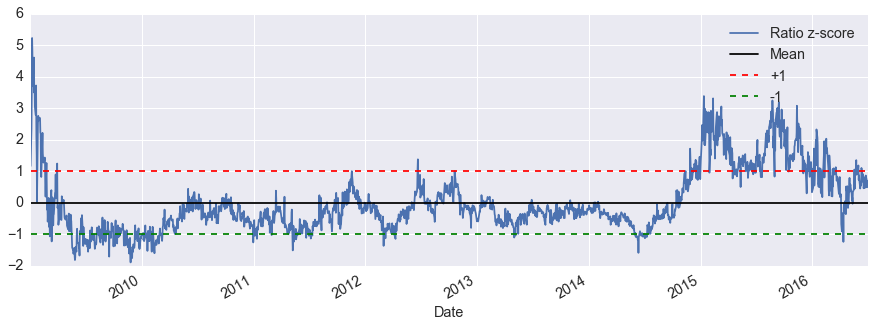

In [132]:
normalised_ratio = static_zscore(Y/X)
normalised_ratio.plot()
plt.axhline(normalised_ratio.mean(), color='black')
plt.axhline(1.0, color='red', linestyle='--')
plt.axhline(-1.0, color='green', linestyle='--')
plt.legend(['Ratio z-score', 'Mean', '+1', '-1']);

The above assumption however is technically inorrect, as in general returns are not normally distributed and rather tend to have 'fat tails'. The figure below clearly shows how a normal distribution fit to ratio histogram isn't good.


mu=-9.40046203383e-16, sigma=1.0
normalised_ratio.mean=-9.40046203383e-16, normalised_ratio.std=1.00025849813


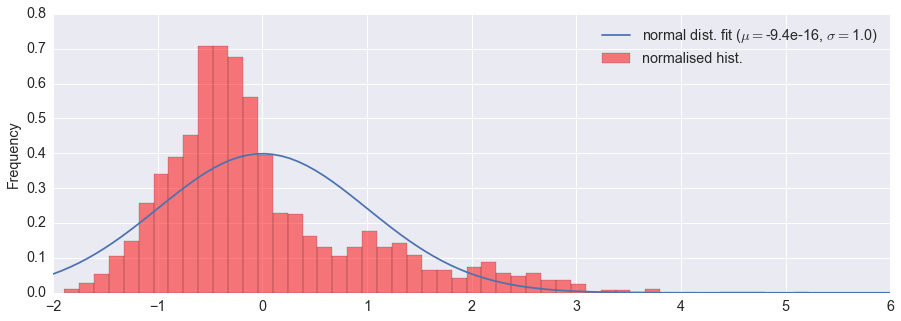

In [127]:
from scipy.stats import norm
import matplotlib.mlab as mlab

# Histogram
_ = normalised_ratio.plot.hist(alpha=0.5, bins=50, normed=True, color='r', label='normalised hist.')
# normalised_ratio.plot.hist(alpha=0.5, bins=50)  # this won't fit the line below

# Get the mu and sigma of the data assuming a gaussian distribution
(mu, sigma) = norm.fit(normalised_ratio)  # because this has been normalised, mu should be close to zero and sigma close to one
print "mu={0}, sigma={1}".format(mu, sigma)
print "normalised_ratio.mean={0}, normalised_ratio.std={1}".format(normalised_ratio.mean(), normalised_ratio.std())


# Fit a normal pdf with mu and sigma as above
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
_ = plt.plot(x, mlab.normpdf(x, normalised_ratio.mean(), normalised_ratio.std()), label="normal dist. fit ($\mu=${0:.2g}, $\sigma=${1})".format(mu, sigma))
_ = plt.legend()

#### Rolling Z-score

In general, taking a statistic over the whole dataset isn't recommended because there can be regime changes, outliers, etc. If the market is moving up, and both securities with it, then the average price over the last 3 years may not be representative of today. For this reason traders often use statistics that rely on rolling windows of the most recent data.

It is also sometimes desirable to 'smooth out' the fluctuations in the data by taking _rolling statistics_ of different periods. Shorter periods are more jumpy and less reliable, but respond to new information quickly. Longer periods are smoother, but take more time to incorporate new information.

Witht this in mind, we can define a 'rolling Z-score' based on short and long window statistics as follows

In [128]:
# # Quandl version:
# def static_zscore(series):
#     return (series - series.mean()) / np.std(series)

# Quandl version:
def rolling_zscore(series):
    return (series.rolling(window=10).mean() - series.rolling(window=60).mean()) / series.rolling(window=60).std()

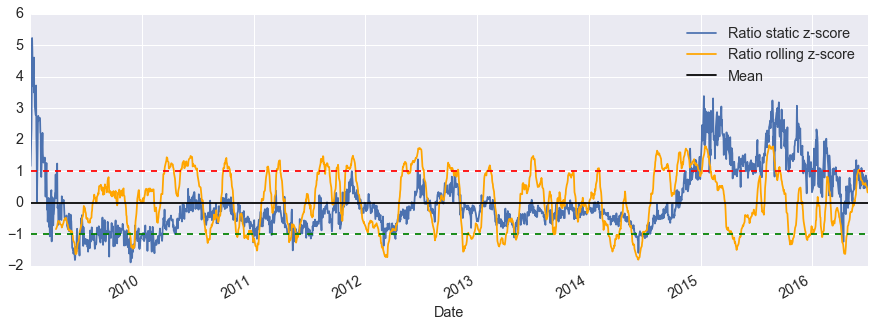

In [143]:
normalised_rolling_ratio = rolling_zscore(Y/X)

# plotting
normalised_ratio.plot()
normalised_rolling_ratio.plot(color='orange')
plt.axhline(normalised_ratio.mean(), color='black')
plt.axhline(1.0, color='red', linestyle='--')
plt.axhline(-1.0, color='green', linestyle='--')
plt.legend(['Ratio static z-score', 'Ratio rolling z-score', 'Mean']);

We see the rolling z-score also would be taking more often positions than the static z-score.

# To do

* lags plot
* partial autocorrelation function plot vs autocorrelation plot
* have not explained why we need returns instead of price levels, should include unit root test comparison between
price level and returns, and also a histogram of the returns of the price for each series and for their difference
after calculating the beta (hedge ratio)